In [114]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv

--2021-10-11 20:14:27--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 7077973 (6,8M) [text/plain]
Сохранение в: «AB_NYC_2019.csv»

AB_NYC_2019.csv     100%[===================>]   6,75M  3,35MB/s    за 2,0s    

2021-10-11 20:14:30 (3,35 MB/s) - «AB_NYC_2019.csv» сохранён [7077973/7077973]



In [8]:
df = pd.read_csv('AB_NYC_2019.csv')

In [20]:
df.id.count()

48895

## Explore the data

<AxesSubplot:xlabel='price', ylabel='Count'>

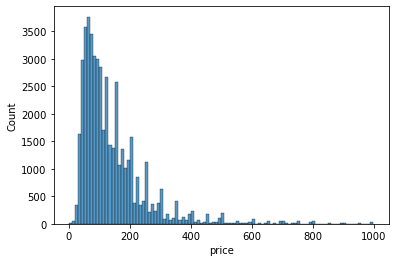

In [31]:
plt.figure(figsize=(6, 4))

sns.histplot(df.price[df.price < 1000], bins=100)

## Features selection

In [35]:
df = df[['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 
        'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]

In [37]:
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,NaN,1,365
3,40.68514,-73.95976,89,1,270,4.64,1,194
4,40.79851,-73.94399,80,10,9,0.10,1,0


## Question 1

In [63]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## Question 2

In [52]:
df.minimum_nights.median()

3.0

In [56]:
np.random.seed(42)

In [124]:
def split_df(df):
    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]
    df_train = df_shuffled[:n_train].copy()
    df_val = df_shuffled[n_train:n_train + n_val].copy()
    df_test = df_shuffled[n_train + n_val:].copy()
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    return df_train, df_val, df_test

In [96]:
print(len(df_train))
print(len(df_val))
print(len(df_test))

print('Total:', (len(df_train) + len(df_test) + len(df_val)))

29337
9779
9779
Total: 48895


In [88]:
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

In [90]:
del df_train['price']
del df_val['price']
del df_test['price']

## Question 3

In [98]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [100]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [99]:
base = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
        'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

### Fill with zeros

RMSE: 0.6458737984815389


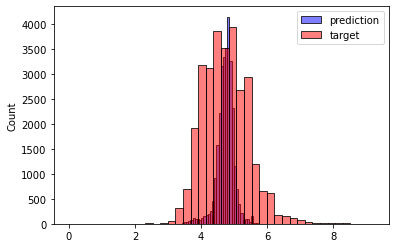

In [102]:
def prepare_X(df):
    df_num = df[base].copy()
    df_num = df_num.fillna(0)
    
    X = df_num.values
    return X

X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)

print('RMSE:', rmse(y_train, y_pred))

sns.histplot(y_pred, label='prediction', color='blue', alpha=0.5, bins=40)
sns.histplot(y_train, label='target', color='red', alpha=0.5, bins=40)

plt.legend()
plt.show()

### Fill with mean

RMSE: 0.6458781793876185


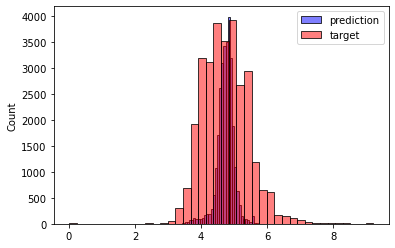

In [117]:
def prepare_X(df):
    df_num = df[base].copy()
    reviews_mean = df_num.reviews_per_month.mean()
    df_num['reviews_per_month'] = df_num['reviews_per_month'].fillna(reviews_mean)
    
    X = df_num.values
    return X

X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)

print('RMSE:', rmse(y_train, y_pred))

sns.histplot(y_pred, label='prediction', color='blue', alpha=0.5, bins=40)
sns.histplot(y_train, label='target', color='red', alpha=0.5, bins=40)

plt.legend()
plt.show()

## Question 4

In [118]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [121]:
r_list = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

def prepare_X(df):
    df_num = df[base].copy()
    df_num = df_num.fillna(0)
    
    X = df_num.values
    return X

for r in r_list:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    
    score = rmse(y_val, y_pred)
    print(r, w0, round(score, 2))

0 -420.5019366399494 0.65
1e-06 -420.4524103423736 0.65
0.0001 -415.6064019115857 0.65
0.001 -376.1895809834037 0.65
0.01 -193.07408162155016 0.66
0.1 -32.90379432247389 0.68
1 -3.5383687898293266 0.69
5 -0.7113440403291251 0.69
10 -0.3553032925628441 0.69


## Question 5

In [122]:
def prepare_X(df):
    df_num = df[base].copy()
    df_num['reviews_per_month'] = df_num['reviews_per_month'].fillna(0)
    
    X = df_num.values
    return X

In [125]:
seeds_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

for seed in seeds_list:
    np.random.seed(seed)
    
    df_train, df_val, df_test = split_df(df)
    
    y_train = np.log1p(df_train.price.values)
    y_val = np.log1p(df_val.price.values)
    y_test = np.log1p(df_test.price.values)
    
    del df_train['price']
    del df_val['price']
    del df_test['price']
    
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    
    score = rmse(y_val, y_pred)
    scores.append(score)
    
    print(seed, score)
    
std = np.std(scores)
round(std, 3)

0 0.6550012880644479
1 0.6463344355297427
2 0.6476971087862929
3 0.6375064196459491
4 0.644716150215017
5 0.630655134868338
6 0.6298548201232138
7 0.6506688157347473
8 0.6488949813743157
9 0.643658970786605


0.008

## Question 6

In [134]:
np.random.seed(9)

df_train, df_val, df_test = split_df(df)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

df_train_val = pd.concat([df_train, df_val])
y_train_val = np.concatenate([y_train, y_val])

X_train_val = prepare_X(df_train_val)
w0, w = train_linear_regression_reg(X_train_val, y_train_val, r=0.001)

X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)

score = rmse(y_test, y_pred)
round(score, 2)

0.65